In [2]:
import os
import cv2
import h5py
import numpy as np
import os.path as osp
import SimpleITK as sitk
import matplotlib.pyplot as plt
from medpy import metric


In [3]:
def calculate_metric_percase(pred, gt):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0:
        dice = metric.binary.dc(pred, gt)
        hd95 = metric.binary.hd95(pred, gt)
        dc = metric.binary.dc(pred, gt)
        jc = metric.binary.jc(pred, gt)
        asd = metric.binary.asd(pred, gt)
        assd = metric.binary.assd(pred, gt)
        precision = metric.binary.precision(pred, gt)
        ravd = metric.binary.ravd(pred, gt)
        return dice, hd95, dc, jc, asd, assd, precision, ravd
    else:
        return 0, 0, 0, 0, 0, 0, 0, 0


In [4]:
def img_seg_rgb(img_arr, pred_arr, gt_arr, alpha=0.8, colors \
                = [(0, 0, 0), (94,193,205), (243,228,63), (255,140,0)]):
    image = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2BGR)
    pred = cv2.cvtColor(pred_arr, cv2.COLOR_GRAY2BGR)
    label = cv2.cvtColor(gt_arr, cv2.COLOR_GRAY2BGR)
    overlay_pred = image.copy()
    overlay_gt = image.copy()
    for i in range(1, 4):
        overlay_pred[np.all(pred == i, axis=-1)] = \
            ((alpha * np.array(colors[i][::-1])/256) + \
             ((1 - alpha) * overlay_pred[np.all(pred == i, axis=-1)]))
        overlay_gt[np.all(label == i, axis=-1)] = \
            ((alpha * np.array(colors[i][::-1])/256) + \
             ((1 - alpha) * overlay_gt[np.all(label == i, axis=-1)]))
    # 将BGR转换为RGB格式
    seg_pred = cv2.cvtColor(overlay_pred, cv2.COLOR_BGR2RGB)
    seg_gt = cv2.cvtColor(overlay_gt, cv2.COLOR_BGR2RGB)
    return seg_pred, seg_gt

patient005_frame13
### base => dice | hd95:  [  0.49921664 128.13066024]
### dmpls => dice | hd95:  [0.87265411 1.74535599]
### EM => dice | hd95:  [ 0.81801088 45.84235093]
### MLoss => dice | hd95:  [0.8617635  1.55009385]
### pclmix => dice | hd95:  [0.89245425 1.13807119]
### s2l => dice | hd95:  [ 0.826714   54.03849169]
### sc-net => dice | hd95:  [0.88362315 1.47140452]
### trimix => dice | hd95:  [ 0.87677735 25.04594944]
### upper => dice | hd95:  [0.89292874 1.13807119]
### ustm => dice | hd95:  [  0.70745825 108.23289106]


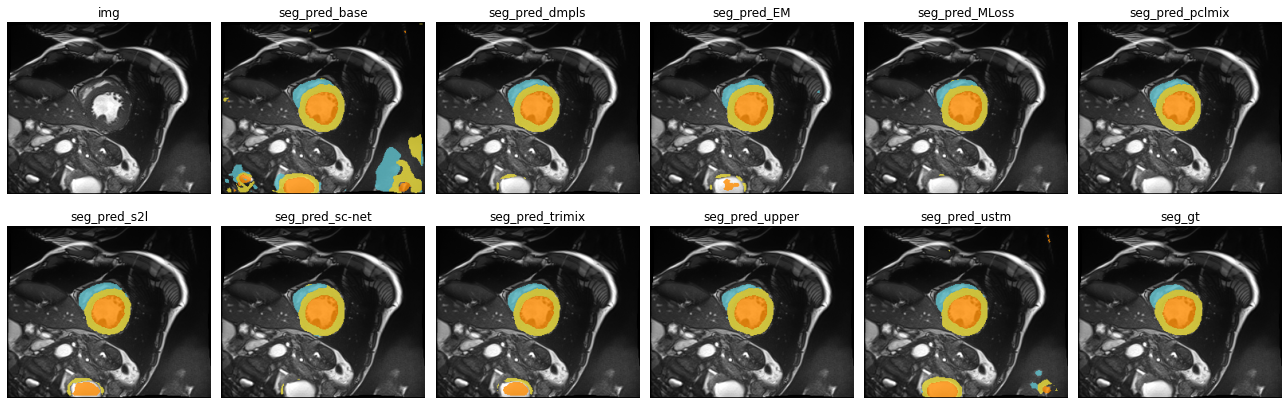

In [8]:
from PIL import Image
from scipy import misc

slice_id = 5
root = r'../results/'
exps = os.listdir(root)
cases = set()
for case_i in os.listdir(osp.join(root, exps[0])):
    if case_i.endswith('gt.nii.gz'):
        cases.add(case_i[:18])
# print(cases)
case = 'patient005_frame13'

# for case in sorted(cases):
print(case)
img_itk = sitk.ReadImage(osp.join(root, exps[0], case + '_img.nii.gz'))
img_arr = sitk.GetArrayFromImage(img_itk)
pred_itk = {}
pred_arr = {}
seg_pred = {}
gt_itk = sitk.ReadImage(osp.join(root, exps[0], case + '_gt.nii.gz'))
gt_arr = sitk.GetArrayFromImage(gt_itk)
for exp in exps:
    pred_itk[exp] = sitk.ReadImage(osp.join(root, exp, case + '_pred.nii.gz'))
    pred_arr[exp] = sitk.GetArrayFromImage(pred_itk[exp])
    
    metric_list = []
    for i in range(1, 4):
        metric_list.append(calculate_metric_percase(pred_arr[exp] == i, gt_arr == i))
    print(f'### {exp} => dice | hd95: ', np.mean(metric_list, axis=0)[:2])

    seg_pred[exp], seg_gt = img_seg_rgb(
        img_arr[slice_id,...], pred_arr[exp][slice_id,...], gt_arr[slice_id,...])
    
    # print(seg_pred[exp].size - np.sum(seg_pred[exp] == seg_gt))

num_fig = len(exps) + 2
plt.figure(figsize=(num_fig*1.5, num_fig*0.5))

plt.subplot(2, int(np.ceil(num_fig/2)), 1)
plt.imshow(img_arr[slice_id,...], cmap='gray')
plt.axis('off')
plt.title('img')
Image.fromarray((img_arr[slice_id,...]*255).astype(np.uint8)).save('../figs/image.jpg')

for i, exp in enumerate(exps):
    plt.subplot(2,int(np.ceil(num_fig/2)),i+2)
    plt.imshow(seg_pred[exp], cmap='gray')
    plt.axis('off')
    plt.title(f'seg_pred_{exp}')
    Image.fromarray((seg_pred[exp]*255).astype(np.uint8)).save(f'../figs/{exp}.jpg')

plt.subplot(2, int(np.ceil(num_fig/2)) ,num_fig)
plt.imshow(seg_gt, cmap='gray')
plt.axis('off')
plt.title('seg_gt')
Image.fromarray((seg_gt*255).astype(np.uint8)).save('../figs/label.jpg')

plt.tight_layout()
plt.show()